# Reciprocity and sensitivity kernels for sea level fingerprints

This notebook illustrates the reciprocity relations discussed in the paper by Al-Attar *et al.* (2023)
 of the same name which is soon to be submitted. In particular, this notebook includes code used to generate 
 all the figures included within that paper. Note that all quantities within the calculations have SI units, but the form of these units is not always shown.

## Setting up the codes

First, we load in the necesarry Python modules. The module ```SLmod.py``` contains much of the code needed for the calculations.

In [5]:
%load_ext autoreload
%autoreload 2

# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pyshtools as pysh
import SLmod as SL
import RFmod as RF
from numpy import pi as pi

#set plotting parameters
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [16, 8]

# get values for some physical parameters
b = SL.b
g = SL.g
G = SL.G
rhoi = SL.rhoi
rhow = SL.rhow
rhos = SL.rhos

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Now we read in the present day distribution of sea level and ice. This is taken from the ice6g model of:

https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014JB011176

The values of the fields are interpolated onto a Gauss Legendre grid at the chosen expansion order. Note that for the calculations in this notebook L = 256 or higher is a sensible value. The maximum possible is L = 1024, this being set by the Love numbers that have been pre-calculated and are read in below. The code also works out the ocean function from sea level and ice thickness. 

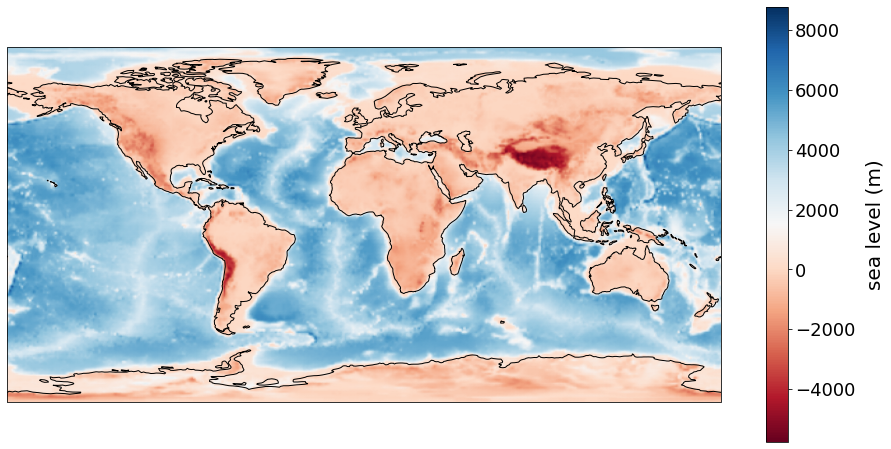

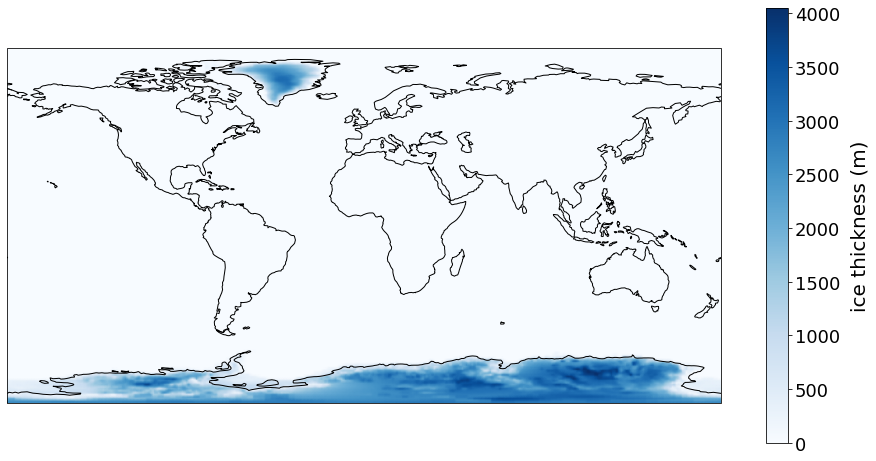

fraction of surface which is ocean =  0.7118907012236343


In [6]:
# set the truncation degree
L=256

# read in the present day sea level and ice thickness
sl0,ice0 = SL.get_sl_ice_data(L)

# plot these fields
SL.plot(sl0,label = 'sea level (m)')
SL.plot(ice0,label = 'ice thickness (m)',clim_pos = True)

# compute the ocean function
C = SL.ocean_function(sl0,ice0)

# work out the ocean area and check the value
A = SL.surface_integral(C)
A_earth = 4*pi*b**2
print('fraction of surface which is ocean = ',A/A_earth)


## Solving the sea level equation to make a synthetic data set


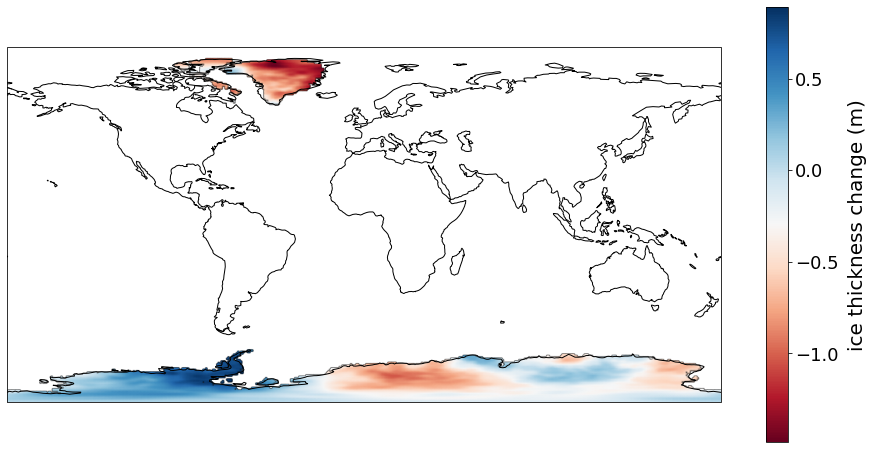

iteration =  1 relative change =  0.03136030612130458
iteration =  2 relative change =  0.0037003988968466466
iteration =  3 relative change =  0.0006760888194659763
iteration =  4 relative change =  0.0001598477410808407
iteration =  5 relative change =  3.975128155214158e-05
iteration =  6 relative change =  1.0275993153623657e-05
iteration =  7 relative change =  2.7560848852815346e-06
iteration =  8 relative change =  7.659885721450817e-07
iteration =  9 relative change =  2.2004897408817827e-07
iteration =  10 relative change =  6.511384606441797e-08
iteration =  11 relative change =  1.9869153189280262e-08
iteration =  12 relative change =  6.162883735143144e-09


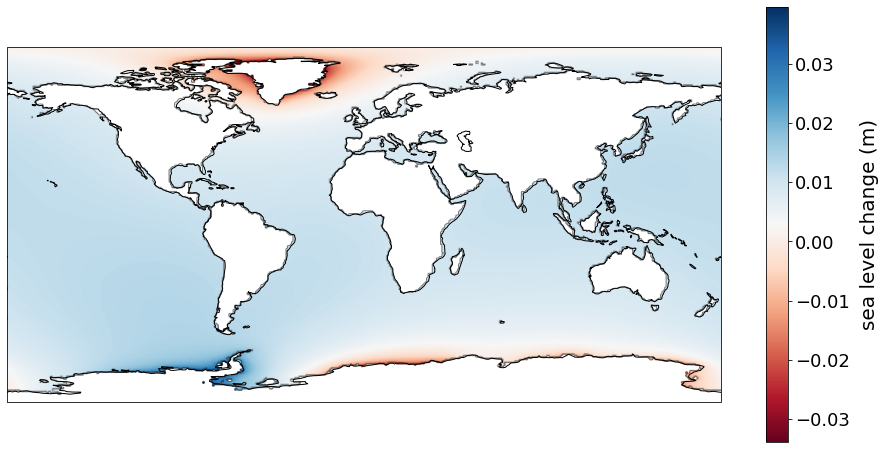

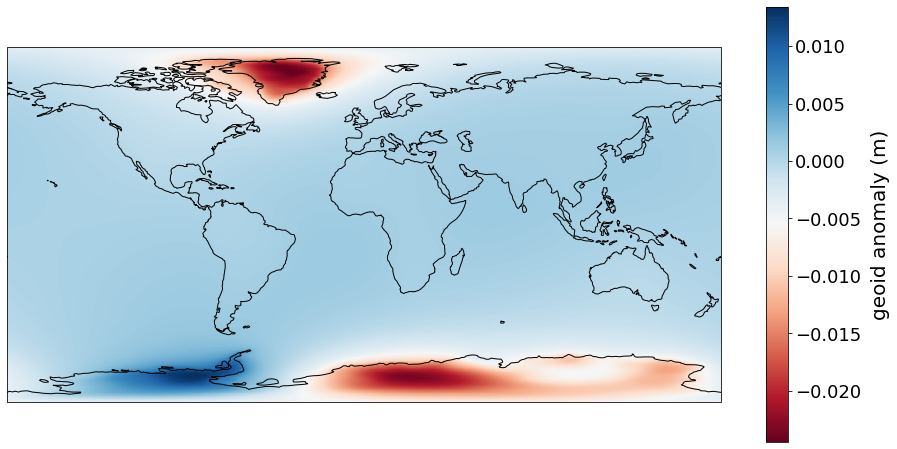

In [13]:
# set to true to use a random ice change model
use_random = True

if(use_random):
    Q = RF.sobolev_covariance(L,s = 2,mu = 0.2,b = b)
    zeta_north = -rhoi*SL.greenland_mask(sl0,ice0,val = 0.)*RF.random_field(Q,b=b)
    zeta_south = -rhoi*SL.antarctica_mask(sl0,ice0,val = 0.)*RF.random_field(Q,b=b)
else:
    zeta_north = -rhoi*SL.zero_southern_hemisphere(ice0)
    zeta_south = -rhoi*SL.zero_northern_hemisphere(ice0)
        

    
# normalise by GMSL contributions
GMSL_north = SL.bathtub(C,zeta_north)
GMSL_south = SL.bathtub(C,zeta_south)
zeta_north /= GMSL_north
zeta_south /= GMSL_south

# set the rate of GMSL change in mm
GMSL = 0.005

# set the northern and southern fractions
f_north = 0.2
f_south = 1.-f_north

# set the combined ice load
zeta = GMSL*(f_north*zeta_north + f_south*zeta_south)

zeta = GMSL*(zeta_north + zeta_south)

# plot the result with suitable mask
ice_mask = SL.ice_mask(sl0,ice0)
SL.plot(ice_mask*zeta/SL.rhoi,label = r'ice thickness change (m)')

# solve the fingerprint problem
sl,u,phi,om,psi = SL.fingerprint(C,zeta)
ocean_mask = SL.ocean_mask(sl0,ice0)

# plot the result globally
SL.plot(sl*ocean_mask,clim_scale = 1,label = r'sea level change (m)')

SL.plot(-1*phi/g,clim_scale = 1,label = r'geoid anomaly (m)')



## Sensitivity kernel for sea level at a given location


iteration =  1 relative change =  0.007498751146103031
iteration =  2 relative change =  0.0002832209368633219
iteration =  3 relative change =  3.583549621191926e-05
iteration =  4 relative change =  7.01818316810871e-06
iteration =  5 relative change =  1.530336846492725e-06
iteration =  6 relative change =  3.594346923909825e-07
iteration =  7 relative change =  9.047590290107059e-08
iteration =  8 relative change =  2.4282234779033007e-08
iteration =  9 relative change =  6.950616430359786e-09


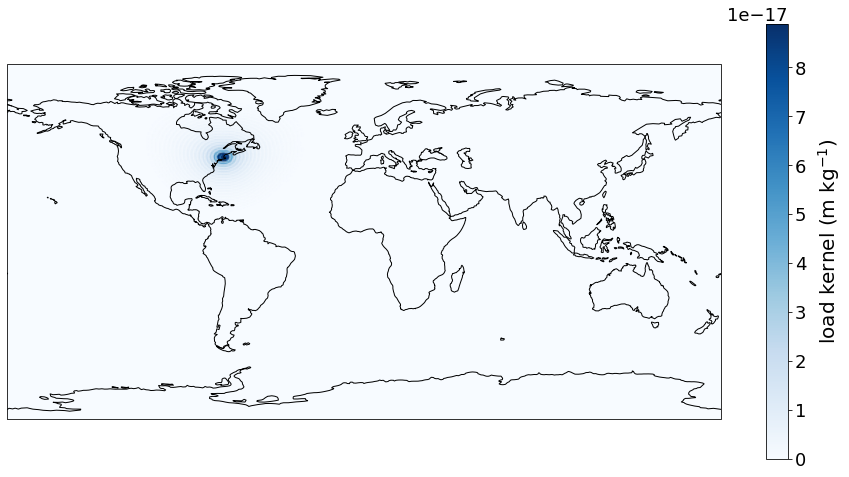

direct sea level value =  0.004618165037407445
left hand side         =  0.004618165037407452
right hand side        =  0.0046181657974589015
relative difference    =  1.6457866784153024e-07


In [7]:
# set the observation point to Boston
lat =  42.3601
lon = -71.0589


# compute the adjoint load
zeta_d,_,_,_ = SL.sea_level_load(L,lat,lon,angle = 0.)

# solve the sea level equation for SL^{\dagger} and plot
sl_d,_,_,_,_ = SL.fingerprint(C,zeta_d)
SL.plot(sl_d,label = r'load kernel (m kg$^{-1}$)',clim_pos = True,clim_scale = 0.1)


# set the value of sea level directly from the field 
sl_direct = SL.point_evaluation(sl,lat,lon)

# evaluate the sea level by integration against the delta load
lhs = SL.surface_integral(zeta_d*sl)

# now get the value by integrating the sensitivity kernel against the direct load
rhs = SL.surface_integral(sl_d*zeta)

# print the values out along with the relative difference
print('direct sea level value = ',sl_direct)
print('left hand side         = ',lhs)
print('right hand side        = ',rhs)
print('relative difference    = ', np.abs((lhs-rhs)/lhs))


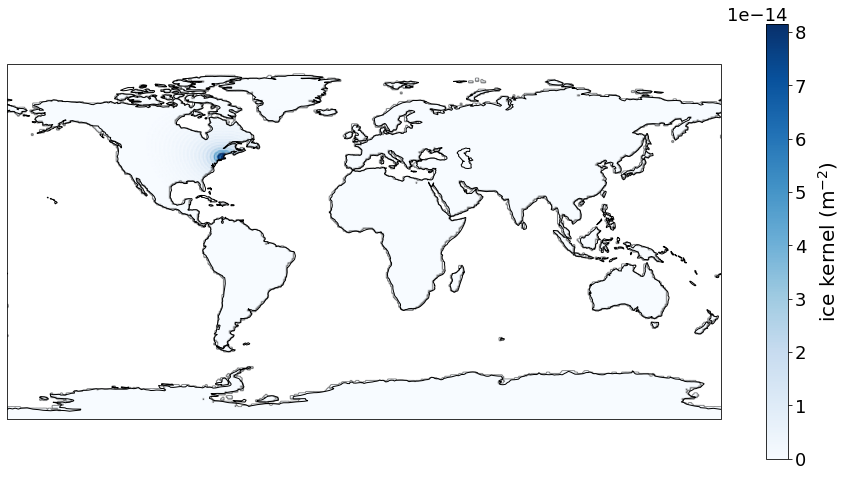

In [8]:
# define and plot the sensitivity kernel with respect to ice thickness
K = SL.rhoi*(1-C)*sl_d
land_mask = SL.land_mask(sl0,ice0)
SL.plot(land_mask*K,label = r'ice kernel (m$^{-2}$)',clim_pos = True,clim_scale = 0.1)

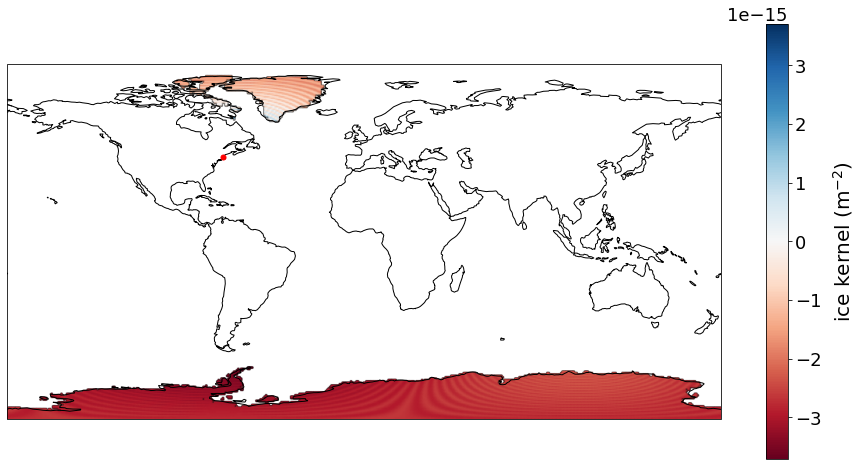

In [9]:
# re-define the kernel such that it is non-zero only where there is grounded ice
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-2}$)',marker = [lat,lon])

iteration =  1 relative change =  0.013156394692021347
iteration =  2 relative change =  0.0005963222416013993
iteration =  3 relative change =  7.416965948410276e-05
iteration =  4 relative change =  1.4487795971970605e-05
iteration =  5 relative change =  3.156279007126248e-06
iteration =  6 relative change =  7.408105205033747e-07
iteration =  7 relative change =  1.8636060911661412e-07
iteration =  8 relative change =  4.9989090825247605e-08
iteration =  9 relative change =  1.4296439090998618e-08
iteration =  10 relative change =  4.369973802146108e-09


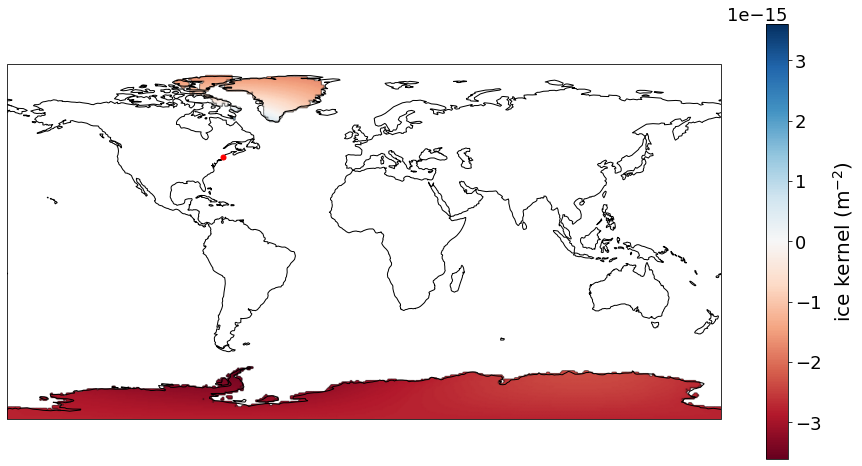

In [10]:
# compute the adjoint load for a SMOOTHED point load
zeta_d,_,_,_ = SL.sea_level_load(L,lat,lon,angle = 1.)

# solve the sea level equation for SL^{\dagger} and plot
sl_d,_,_,_,_ = SL.fingerprint(C,zeta_d)

# set and plot the kernel projected onto regions of grounded ice
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-2}$)',marker = [lat,lon])


## Sensitivity kernel for vertical displacement measurement



iteration =  1 relative change =  0.004819684087870496
iteration =  2 relative change =  7.85749759766684e-05
iteration =  3 relative change =  1.8586154650663015e-05
iteration =  4 relative change =  4.634764791501651e-06
iteration =  5 relative change =  1.1940995841558686e-06
iteration =  6 relative change =  3.1823565446161256e-07
iteration =  7 relative change =  8.772176959172053e-08
iteration =  8 relative change =  2.4965754331229062e-08
iteration =  9 relative change =  7.313024173505076e-09

direct displacement value =  -0.00032646879674668247
left hand side            =  -0.0003264688388158212
right hand side           =  -0.0003264687967466814
relative difference       =  1.2886111884672104e-07

iteration =  1 relative change =  0.008339206783334746
iteration =  2 relative change =  0.00018445824000511209
iteration =  3 relative change =  4.2136973872283094e-05
iteration =  4 relative change =  1.0507506311616896e-05
iteration =  5 relative change =  2.7071374605066733e-06


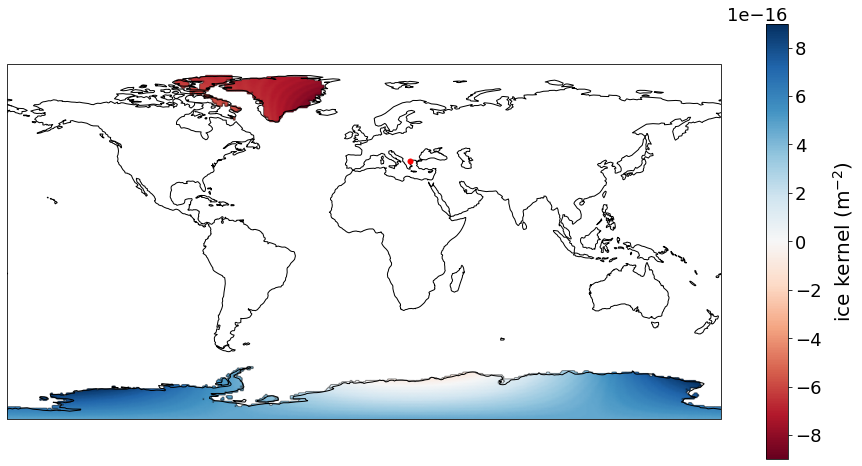

In [11]:
# set the observation point in Thessaloniki
lat = 40.6401
lon = 22.9444
zeta_d,zeta_u_d,zeta_phi_d,kk_d = SL.displacement_load(L,lat,lon,angle = 0)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# get the displacement directly
u_lm = u.expand();
u_direct = pysh.expand.MakeGridPoint(u_lm.coeffs,lat,lon+180)

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct displacement value = ',u_direct)
print('left hand side            = ', lhs)
print('right hand side           = ',rhs)
print('relative difference       = ', np.abs((lhs-rhs)/lhs))
print('')


# compute and plot the sensitivity kernel wrt ice thickness, but smoothing the point load
zeta_d,zeta_u_d,zeta_phi_d,kk_d = SL.displacement_load(L,lat,lon,angle = 1)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-2}$)',marker = [lat,lon])

iteration =  1 relative change =  0.0022952252277258236
iteration =  2 relative change =  0.0001275450220771649
iteration =  3 relative change =  1.594256989309356e-05
iteration =  4 relative change =  2.5662314080407026e-06
iteration =  5 relative change =  5.101609100041212e-07
iteration =  6 relative change =  1.1299069022272421e-07
iteration =  7 relative change =  2.738257052391142e-08
iteration =  8 relative change =  7.290157799209428e-09

direct displacement value =  0.00017736719981447166
left hand side            =  0.00017736726577710353
right hand side           =  0.0001773671998144709
relative difference       =  3.7189857067527906e-07

iteration =  1 relative change =  0.006688727837355043
iteration =  2 relative change =  0.0003159598494569206
iteration =  3 relative change =  3.781040098122708e-05
iteration =  4 relative change =  6.089844266035337e-06
iteration =  5 relative change =  1.1609081318361866e-06
iteration =  6 relative change =  2.5602902874885766e-07
iter

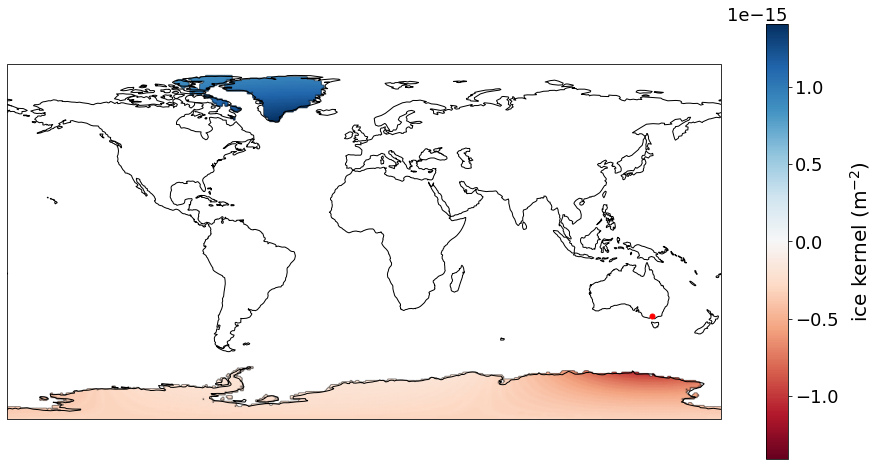

In [12]:
# set the observation point in Melborne
lat = -37.8136
lon = 144.9631
zeta_d,zeta_u_d,zeta_phi_d,kk_d = SL.displacement_load(L,lat,lon,angle = 0)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# get the displacement directly
u_lm = u.expand();
u_direct = pysh.expand.MakeGridPoint(u_lm.coeffs,lat,lon+180)

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct displacement value = ',u_direct)
print('left hand side            = ', lhs)
print('right hand side           = ',rhs)
print('relative difference       = ', np.abs((lhs-rhs)/lhs))
print('')


# compute and plot the sensitivity kernel wrt ice thickness, but smoothing the point load
zeta_d,zeta_u_d,zeta_phi_d,kk_d = SL.displacement_load(L,lat,lon,angle = 1)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
cm = np.max(np.abs(K.data))
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-2}$)',marker = [lat,lon],clim = [-cm,cm])

## Sensitivity kernel for gravitational potential coefficient measurement


iteration =  1 relative change =  0.24579578455674506
iteration =  2 relative change =  0.06029727711367154
iteration =  3 relative change =  0.014972956165834687
iteration =  4 relative change =  0.0037953304252834183
iteration =  5 relative change =  0.0009883058728837883
iteration =  6 relative change =  0.00026522350491493926
iteration =  7 relative change =  7.345165245501383e-05
iteration =  8 relative change =  2.097318302604083e-05
iteration =  9 relative change =  6.15748126301137e-06
iteration =  10 relative change =  1.851475565647295e-06
iteration =  11 relative change =  5.678408676366301e-07
iteration =  12 relative change =  1.7685584935455657e-07
iteration =  13 relative change =  5.5730860312878525e-08
iteration =  14 relative change =  1.7715542744822885e-08
iteration =  15 relative change =  5.66733346036525e-09

direct potential value    =  0.002791601386685215
left hand side            =  0.0027916036630259485
right hand side           =  0.0027916013866852124
rela

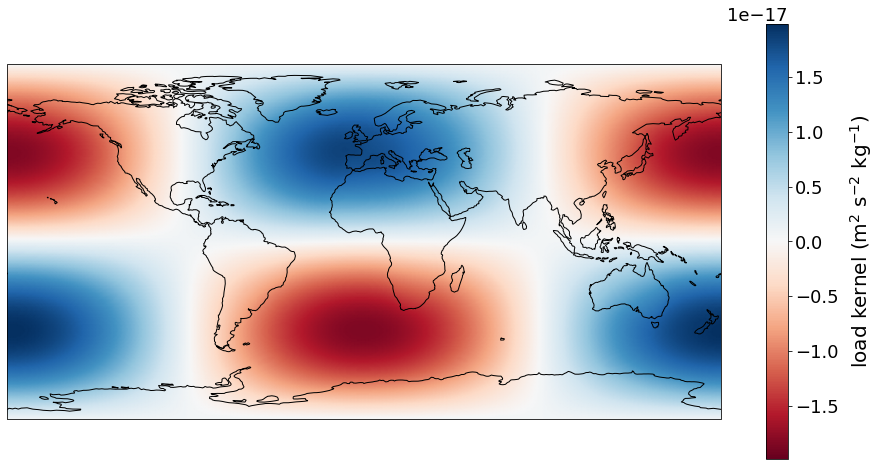

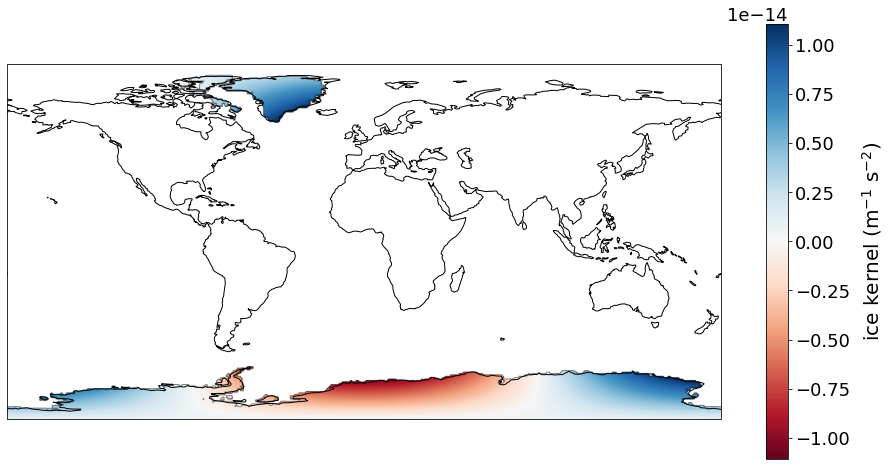

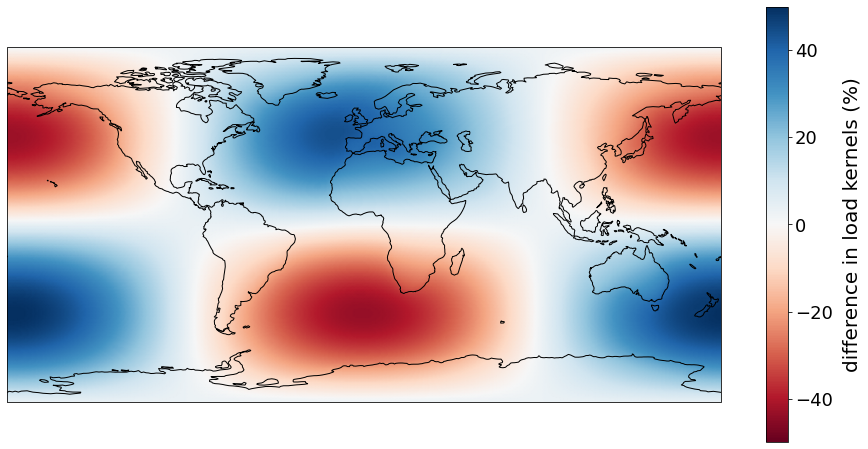

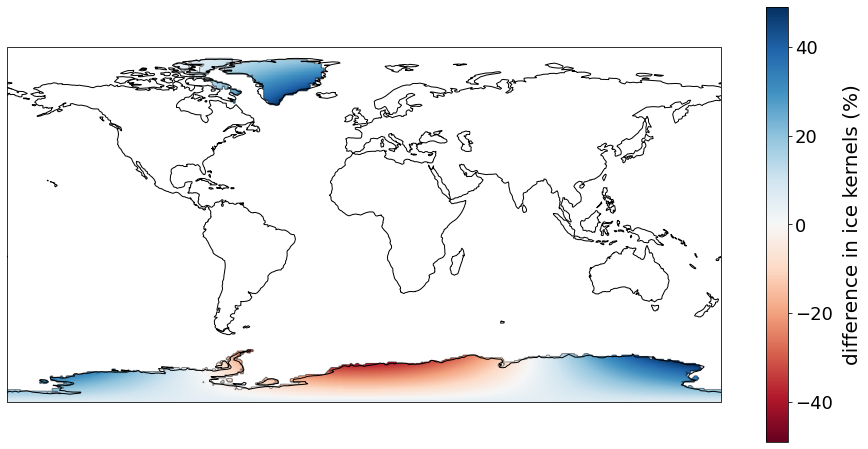

In [12]:
# set the adjoint loads
l = 2
m = 1
zeta_d, zeta_u_d, zeta_phi_d, kk_d = SL.potential_coefficient_load(L,l,m,remove_psi = True)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# get the potential coefficient directly
phi_lm = phi.expand(normalization='ortho')
if(m >= 0):
    phi_direct = phi_lm.coeffs[0,l,m]
else:
    phi_direct = phi_lm.coeffs[1,l,-m]

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct potential value    = ',phi_direct)
print('left hand side            = ',lhs)
print('right hand side           = ',rhs)
print('relative difference       = ',np.abs((lhs-rhs)/lhs))
print('')


# plot the sensitivity kernel wrt zeta
SL.plot(sl_d,label = r'load kernel (m$^{2}$ s$^{-2}$ kg$^{-1}$)')


# plot the sensitivity kernel wrt ice
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-1}$ s$^{-2}$)')

# get the love numbers
_,k,_,_ = SL.love_numbers(L)

# compute the kernel ignoring water loading
K_d_lm = pysh.SHCoeffs.from_zeros(lmax=L,normalization = 'ortho')
if(m > 0):
    K_d_lm.coeffs[0,l,m] = k[l]/SL.b**2
else:
    K_d_lm.coeffs[1,l,-m] = k[l]/SL.b**2   
K_d = K_d_lm.expand(grid = 'GLQ')


# plot the sensitivity kernel wrt zeta minus direct kernel
norm = np.max(np.abs(sl_d.data))
SL.plot(100*(sl_d-K_d)/norm,label = r'difference in load kernels (%)')


# plot the sensitivity kernel wrt ice
K1 = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
K2 = SL.rhoi*(1-C)*K_d*SL.ice_mask(sl0,ice0,val = 0.)
norm = np.max(np.abs(K1.data))
SL.plot(100*ice_mask*(K1-K2)/norm,label = r'difference in ice kernels (%)')


iteration =  1 relative change =  0.04262237639154877
iteration =  2 relative change =  0.0021600920184973575
iteration =  3 relative change =  0.00014986571474822236
iteration =  4 relative change =  1.6265090104205663e-05
iteration =  5 relative change =  2.6719634496652638e-06
iteration =  6 relative change =  5.255439042269298e-07
iteration =  7 relative change =  1.1600389989272978e-07
iteration =  8 relative change =  2.7395941848597477e-08
iteration =  9 relative change =  6.849698256908909e-09

direct potential value    =  0.0005184131572048067
left hand side            =  0.0005184131490992269
right hand side           =  0.0005184131572048069
relative difference       =  1.5635367319202846e-08



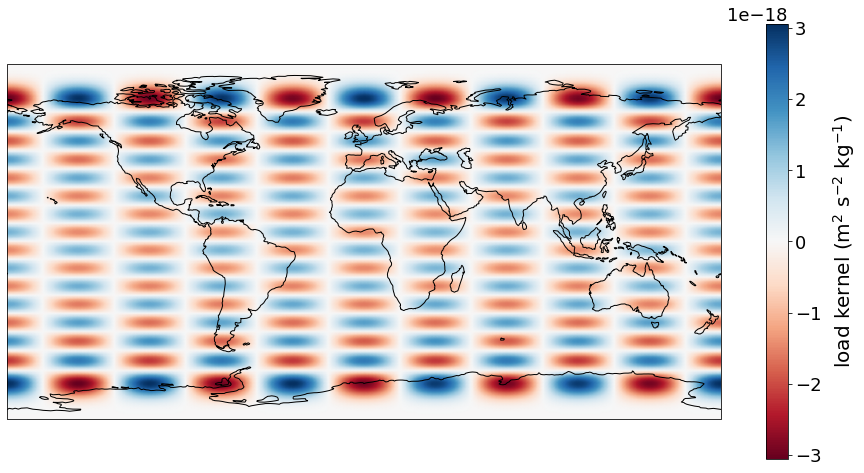

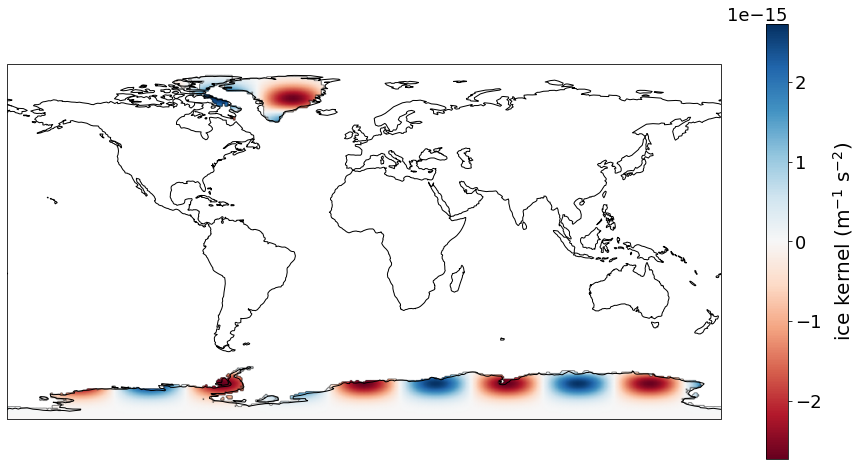

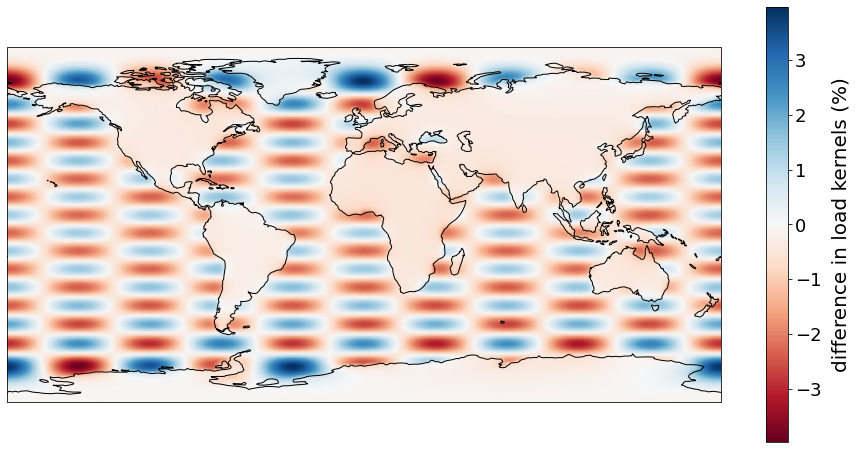

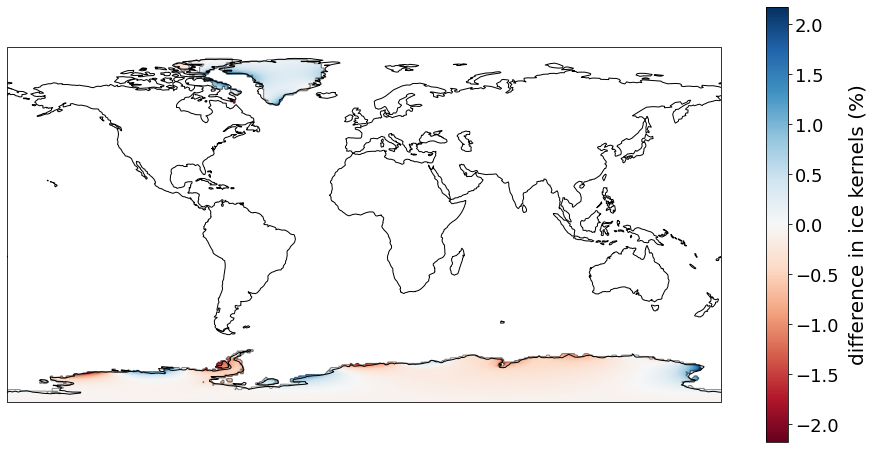

In [14]:
# set the adjoint loads for a higher degree
l = 20
m = 5
zeta_d, zeta_u_d, zeta_phi_d, kk_d = SL.potential_coefficient_load(L,l,m,remove_psi = True)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# get the potential coefficient directly
phi_lm = phi.expand(normalization='ortho')
if(m >= 0):
    phi_direct = phi_lm.coeffs[0,l,m]
else:
    phi_direct = phi_lm.coeffs[1,l,-m]

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct potential value    = ',phi_direct)
print('left hand side            = ',lhs)
print('right hand side           = ',rhs)
print('relative difference       = ',np.abs((lhs-rhs)/lhs))
print('')


# plot the sensitivity kernel wrt zeta
SL.plot(sl_d,label = r'load kernel (m$^{2}$ s$^{-2}$ kg$^{-1}$)')


# plot the sensitivity kernel wrt ice
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-1}$ s$^{-2}$)')

# get the love numbers
_,k,_,_ = SL.love_numbers(L)

# compute the kernel ignoring water loading
K_d_lm = pysh.SHCoeffs.from_zeros(lmax=L,normalization = 'ortho')
if(m > 0):
    K_d_lm.coeffs[0,l,m] = k[l]/SL.b**2
else:
    K_d_lm.coeffs[1,l,-m] = k[l]/SL.b**2   
K_d = K_d_lm.expand(grid = 'GLQ')


# plot the sensitivity kernel wrt zeta minus direct kernel
norm = np.max(np.abs(sl_d.data))
SL.plot(100*(sl_d-K_d)/norm,label = r'difference in load kernels (%)')


# plot the sensitivity kernel wrt ice
K1 = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
K2 = SL.rhoi*(1-C)*K_d*SL.ice_mask(sl0,ice0,val = 0.)
norm = np.max(np.abs(K1.data))
SL.plot(100*ice_mask*(K1-K2)/norm,label = r'difference in ice kernels (%)')


## Sensitivity kernels for Grace load averages

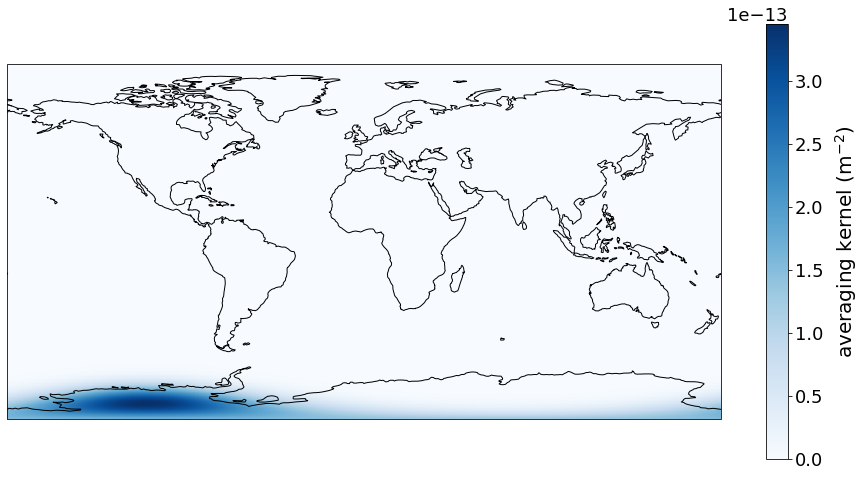

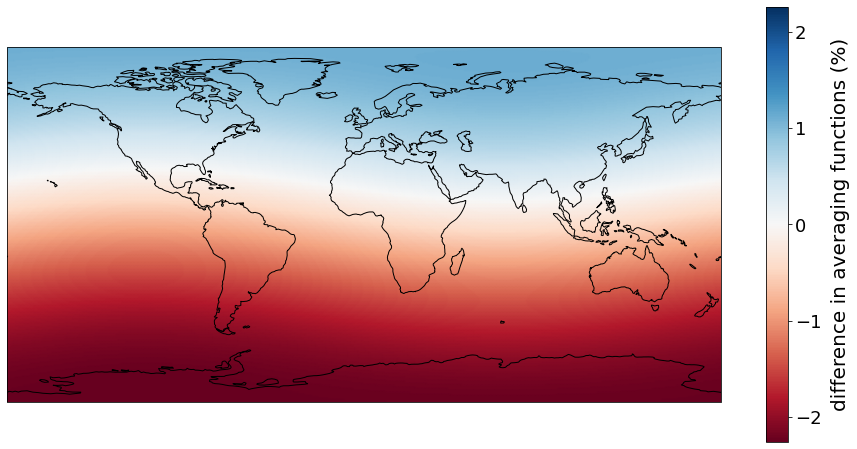

iteration =  1 relative change =  0.019301027473807117
iteration =  2 relative change =  0.0008358429202488901
iteration =  3 relative change =  8.859621680068583e-05
iteration =  4 relative change =  1.815584640876961e-05
iteration =  5 relative change =  3.971452261404151e-06
iteration =  6 relative change =  9.327020665925369e-07
iteration =  7 relative change =  2.3537494912362645e-07
iteration =  8 relative change =  6.34280038133987e-08
iteration =  9 relative change =  1.8040996590919203e-08
iteration =  10 relative change =  5.345980409321043e-09

left hand side            =  -63.694953933905964
right hand side           =  -63.69496041187209
relative difference       =  1.0170297212443847e-07



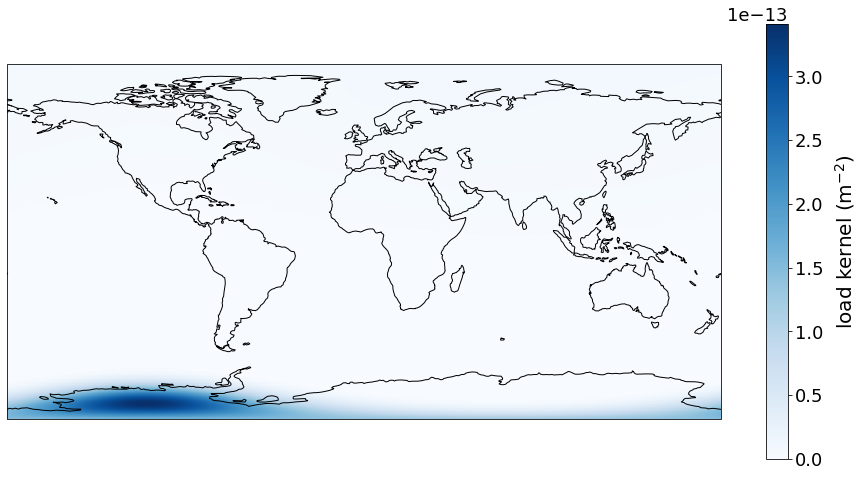

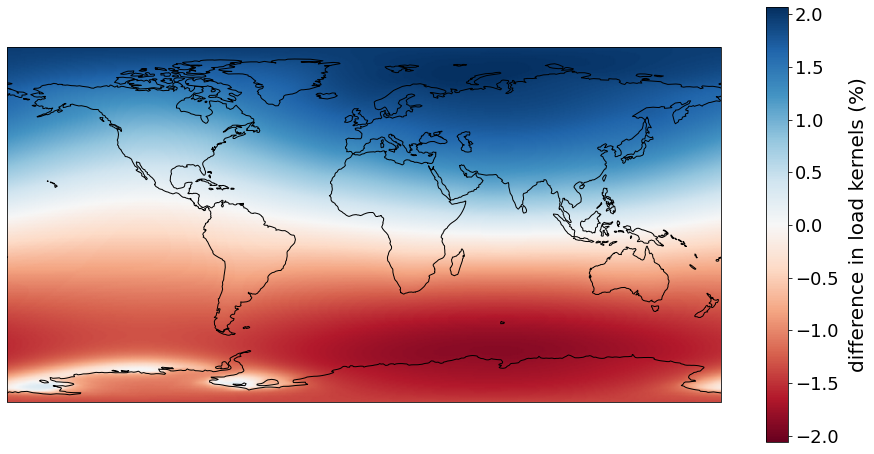

GRACE average of load =  -0.06369496041187209
average of direct load  =  -0.06911042870756512
relative difference with direct load average   =  -7.835963973842681 %


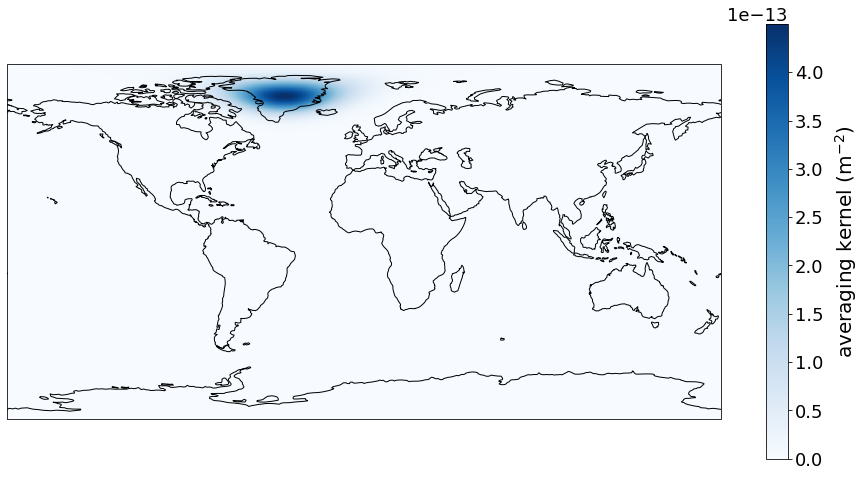

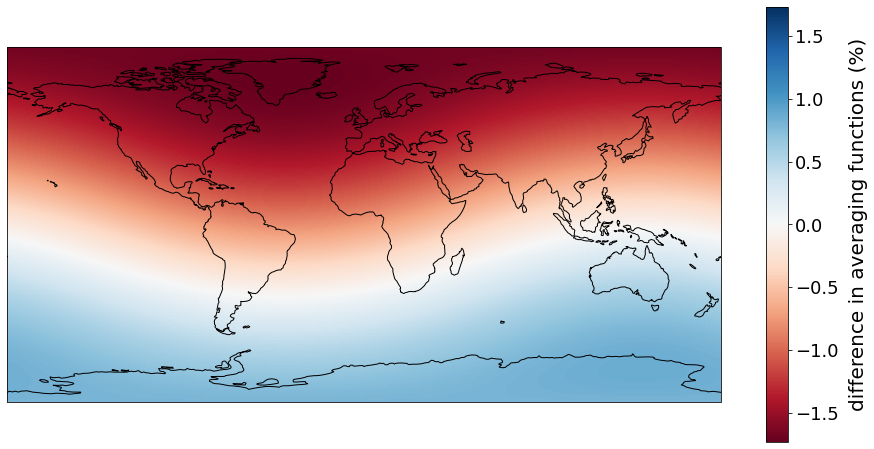

iteration =  1 relative change =  0.021489834141146805
iteration =  2 relative change =  0.0012590815949753379
iteration =  3 relative change =  0.00015129738279389765
iteration =  4 relative change =  3.614727308668962e-05
iteration =  5 relative change =  8.9848351435713e-06
iteration =  6 relative change =  2.333354244001909e-06
iteration =  7 relative change =  6.334978750386629e-07
iteration =  8 relative change =  1.7919064798421353e-07
iteration =  9 relative change =  5.251221127597261e-08
iteration =  10 relative change =  1.583019164771913e-08
iteration =  11 relative change =  4.875903027366475e-09

left hand side            =  -116.94947153645336
right hand side           =  -116.9494744331801
relative difference       =  2.476904515330627e-08



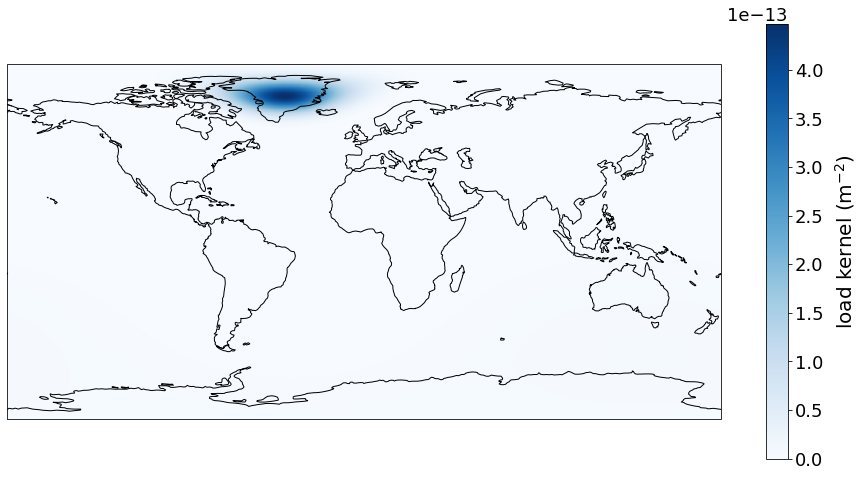

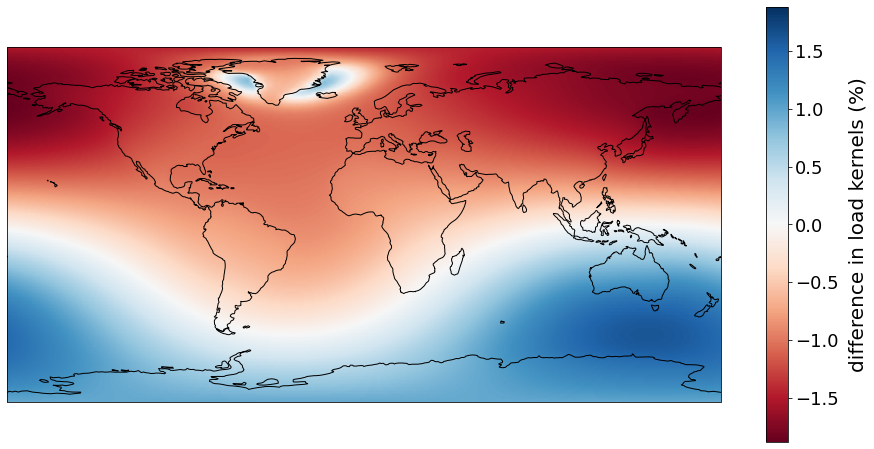

GRACE average of load =  -0.11694947443318002
average of direct load  =  -0.11129318903356454
relative difference with direct load average   =  5.082328441419373 %


In [15]:
# cut out degrees 0 and 1 from averaging function?
cut = False

# truncation degree for GRACE average (LT = 0 means no truncation)
LT = 100


# define the averaging function as in Wahr et al. (1998) targeted at W. Antarctic
w = SL.gaussian_averaging_function(L,r = 800,lat0 = -82.,lon0 = -110.,cut = cut)
SL.plot(w,label = r'averaging kernel (m$^{-2}$)',clim_pos = True)

wc = SL.gaussian_averaging_function(L,r = 800,lat0 = -82.,lon0 = -110.,cut = True)
norm = np.max(np.abs(w.data[:,:]))
SL.plot(100*(wc-w)/norm,label = r'difference in averaging functions (%)')

# form the adjoint loads
zeta_d, zeta_u_d, zeta_phi_d, kk_d  = SL.GRACE_average_load(w,LT = LT)

# solve the adjoint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# check the kernel is working okay
lhs = SL.surface_integral(sl_d*zeta)
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g
print('')
print('left hand side            = ',lhs)
print('right hand side           = ',rhs)
print('relative difference       = ',np.abs((lhs-rhs)/lhs))
print('')

# plot the kernel wrt zeta
SL.plot(sl_d,label = r'load kernel (m$^{-2}$)',cmap = "Blues",clim_pos = True)

GRACE_average = SL.GRACE_average_measurement(phi,w,LT = LT)/SL.rhow
direct_load_average = SL.surface_integral(zeta*w)/SL.rhow

# plot the kernel wrt zeta
norm = np.max(np.abs(w.data[:,:]))
SL.plot(100*(sl_d-w)/norm,label = 'difference in load kernels (%)',clim_sym = True)

print('GRACE average of load = ',GRACE_average)
print('average of direct load  = ',direct_load_average)
print('relative difference with direct load average   = ',100*(GRACE_average-direct_load_average) \
                                                               /direct_load_average,'%')


##########################################################
# now do the same thing but for a Greenland average

# define the averaging function as in Wahr et al. (1998) targeted at Greenland
w = SL.gaussian_averaging_function(L,r = 700,lat0 = 73.,lon0 = -40.,cut = cut)
SL.plot(w,label = r'averaging kernel (m$^{-2}$)',clim_pos = True)

wc = SL.gaussian_averaging_function(L,r = 700,lat0 = 73.,lon0 = -40.,cut = True)
norm = np.max(np.abs(w.data[:,:]))
SL.plot(100*(wc-w)/norm,label = r'difference in averaging functions (%)')

# form the adjoint loads
zeta_d, zeta_u_d, zeta_phi_d, kk_d  = SL.GRACE_average_load(w,LT = LT)

# solve the adjoint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# check the kernel is working okay
lhs = SL.surface_integral(sl_d*zeta)
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g
print('')
print('left hand side            = ',lhs)
print('right hand side           = ',rhs)
print('relative difference       = ',np.abs((lhs-rhs)/lhs))
print('')

# plot the kernel wrt zeta
SL.plot(sl_d,label = r'load kernel (m$^{-2}$)',clim_pos = True)

GRACE_average      = SL.GRACE_average_measurement(phi,w,LT = LT)/SL.rhow
direct_load_average = SL.surface_integral(zeta*w)/SL.rhow


# plot the kernel wrt zeta
norm = np.max(np.abs(w.data[:,:]))
SL.plot(100*(sl_d-w)/norm,label = 'difference in load kernels (%)')

print('GRACE average of load = ',GRACE_average)
print('average of direct load  = ',direct_load_average)
print('relative difference with direct load average   = ',100*(GRACE_average-direct_load_average) \
                                                               /direct_load_average,'%')



## Case 4: Sensitivity kernels for sea surface height

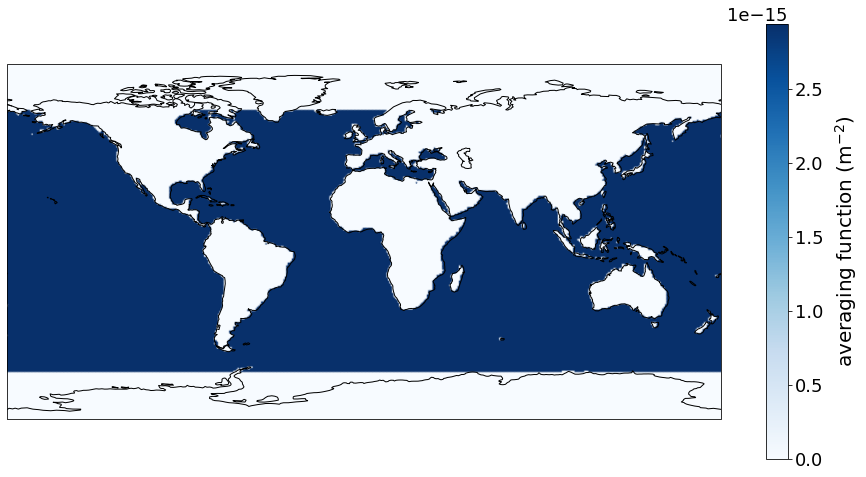

iteration =  1 relative change =  0.009431655356331316
iteration =  2 relative change =  0.0018000596990000027
iteration =  3 relative change =  0.0003989903053466987
iteration =  4 relative change =  8.921379159333109e-05
iteration =  5 relative change =  2.0150644050968456e-05
iteration =  6 relative change =  4.60544617233634e-06
iteration =  7 relative change =  1.0668542844116907e-06
iteration =  8 relative change =  2.5107664481194323e-07
iteration =  9 relative change =  6.022232144211199e-08
iteration =  10 relative change =  1.4776734372843495e-08
iteration =  11 relative change =  3.722634152671196e-09


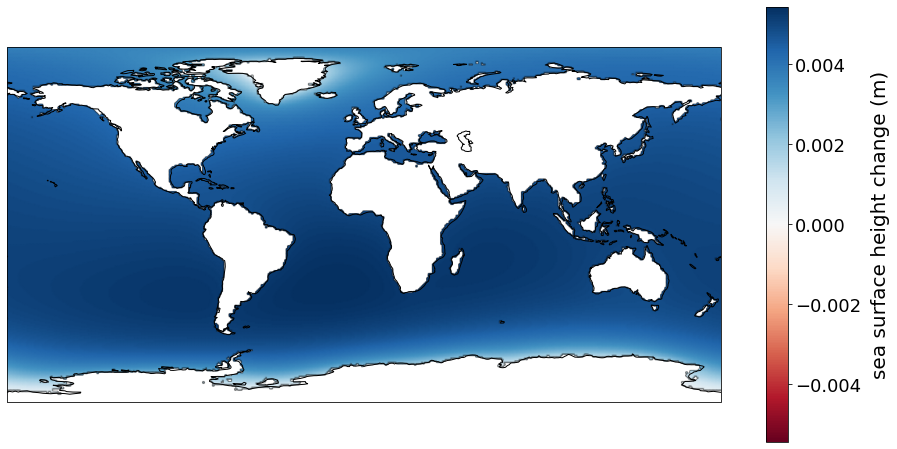


direct ssh value     =  0.0048974615020405034
left hand side       =  0.004897461458590715
right hand side      =  0.004897461502040504
relative difference  =  8.87190012071984e-09



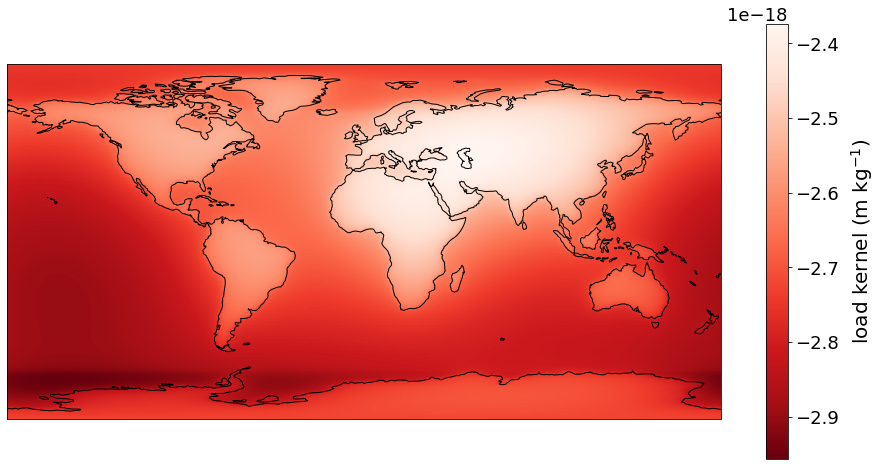

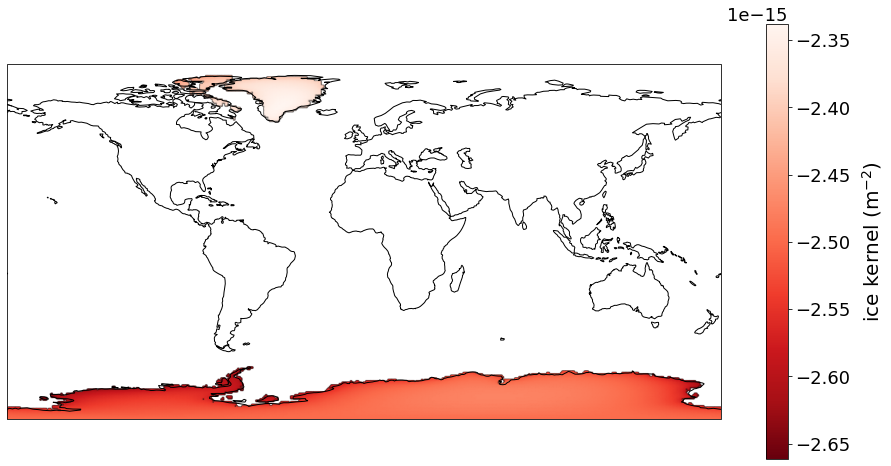

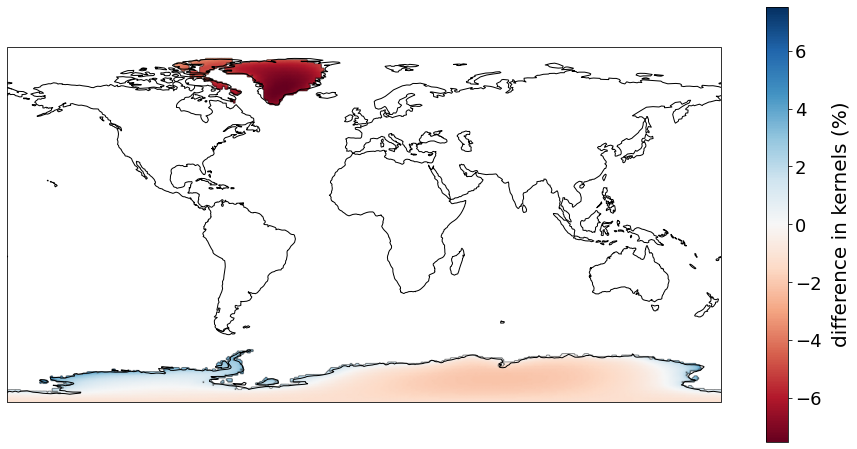

percentage difference from GMSL =  -2.050769959189933 %

iteration =  1 relative change =  0.020810035129174745
iteration =  2 relative change =  0.0025168834371969615
iteration =  3 relative change =  0.0004218633492614692
iteration =  4 relative change =  8.333842199020502e-05
iteration =  5 relative change =  1.8143839733415343e-05
iteration =  6 relative change =  4.260186601360209e-06
iteration =  7 relative change =  1.0734379299108167e-06
iteration =  8 relative change =  2.8867774252608256e-07
iteration =  9 relative change =  8.254289608496889e-08
iteration =  10 relative change =  2.5250184218022648e-08
iteration =  11 relative change =  7.866995083078309e-09


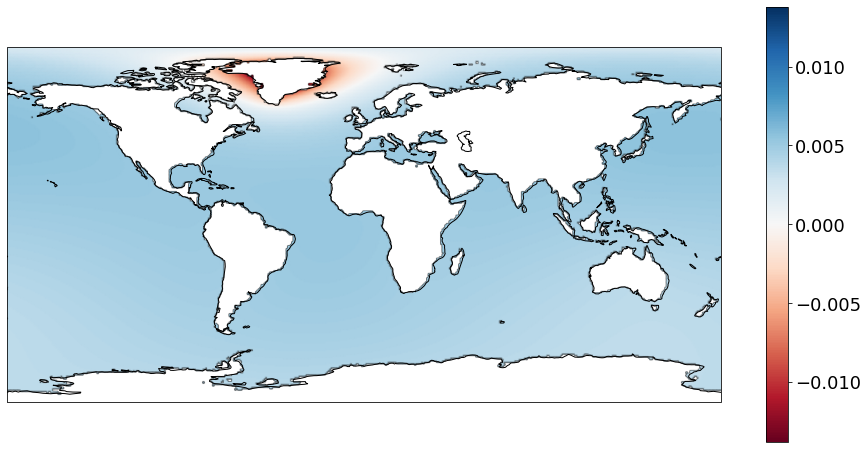

0.004657592372396745

percentage difference from GMSL =  -6.848152552065105 %


In [16]:
# set the adjoint loads
zeta_d, zeta_u_d, zeta_phi_d, kk_d  = SL.sea_altimetery_load(sl0,ice0)

SL.plot(zeta_d,label = r'averaging function (m$^{-2}$)',clim_pos = True)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# form the sea surface height directly
ssh = sl + u + psi/SL.g
SL.plot(ssh*ocean_mask,label = r'sea surface height change (m)')

# set the observational area and form the average
ssh_direct = SL.surface_integral(ssh*zeta_d)

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct ssh value     = ',ssh_direct)
print('left hand side       = ',lhs)
print('right hand side      = ',rhs)
print('relative difference  = ',np.abs((lhs-rhs)/lhs))
print('')


# plot the kernel wrt zeta
SL.plot(sl_d,label = r'load kernel (m kg$^{-1}$)',clim_sym = False,cmap = "Reds_r")

# plot the kernel wrt I
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-2}$)',clim_sym = False,cmap = "Reds_r")

Kval = -SL.rhoi/(SL.rhow*A)
Ki = Kval*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(100*ice_mask*(K-Ki)/Kval,label = r'difference in kernels (%)')

# determine the difference between the altimetery estimate the GMSL
print('percentage difference from GMSL = ',100*(ssh_direct-GMSL)/np.abs(GMSL),"%")
print('')



#######################################################################
# do the same again, but now consider a northern hemisphere only source

zeta_2 = GMSL*zeta_north
sl_2,u_2,phi_2,om_2,psi_2 = SL.fingerprint(C,zeta_2)
ssh_2 = sl_2 + u_2 + psi_2/SL.g
SL.plot(ssh_2*ocean_mask)
ssh_direct = SL.surface_integral(ssh_2*zeta_d)
print(ssh_direct)
print('')
print('percentage difference from GMSL = ',100*(ssh_direct-GMSL)/np.abs(GMSL),"%")
